# <u>Spotify</u> 
### Analytics Practicum I
### Assignment 2
### Professor: Panos Louridas 
## <font color="blue">***Eleni Ralli   (ID:f2822312)*** </font>    


####

For this assignment, we will embark on an investigative journey to demystify Spotify's Valence metric, a measure designed to quantify the happiness conveyed by a track. Our objective is to unravel the mystery surrounding Valence by examining and analyzing various track features that may influence this metric. We will employ inferential statistical methods to identify significant track features that could explain Valence. Furthermore, we will leverage machine learning techniques, employing at least three different methods, to predict Valence based on these features, meticulously tuning hyperparameters to optimize our models. The ultimate goal is to determine which features most significantly affect Valence and to evaluate our predictions using a holdout testing dataset, with our performance measured by the Mean Average Error (MAE).

### Setting up the Spotify API

* To set up the Spotify API, we need to go to http://developer.spotify.com and create an application.

* We take a client ID and a client secret so that our app will be able to use the Spotify API.

#### For the assignment we will use the track.csv which we created as follows:
As you can see in the get_data_from_spotify.py , the data from the music charts are merged together into a single dataframe, and then a list of unique track IDs is created from this unified dataframe and the 'SpotifyFeatures.csv' file.
These unique track IDs are used to retrieve the audio features from the Spotify API, thus creating a new database that combines information from the charts and the features of the tracks. The actual merging of the data based on a column (e.g., the track's ID) occurs in the final stage, when the data returned from the Spotify API are merged with the unified charts dataframe, with the 'song_id' (or 'track_id') column serving as the key for the merge.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error

import glob
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import os
# Setting the current working directory
relative_path = os.getcwd()

In [3]:

tracks_df = pd.read_csv(os.path.join(relative_path, 'tracks.csv'))

In [4]:
tracks_df.columns

Index(['Unnamed: 0', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'song_id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

In [5]:
tracks_df.shape

(187945, 19)

In [6]:
tracks_df.head()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,song_id,uri,track_href,analysis_url,duration_ms,time_signature
0,0,0.681,0.594,7,-7.028,1,0.2820,0.1650,0.000003,0.134,0.5350,186.054,audio_features,5aAx2yezTd8zXrkmtKl66Z,spotify:track:5aAx2yezTd8zXrkmtKl66Z,https://api.spotify.com/v1/tracks/5aAx2yezTd8z...,https://api.spotify.com/v1/audio-analysis/5aAx...,230453,4
1,1,0.720,0.763,9,-4.068,0,0.0523,0.4060,0.000000,0.180,0.7420,101.965,audio_features,5knuzwU65gJK7IF5yJsuaW,spotify:track:5knuzwU65gJK7IF5yJsuaW,https://api.spotify.com/v1/tracks/5knuzwU65gJK...,https://api.spotify.com/v1/audio-analysis/5knu...,251088,4
2,2,0.748,0.524,8,-5.599,1,0.0338,0.4140,0.000000,0.111,0.6610,95.010,audio_features,7BKLCZ1jbUBVqRi2FVlTVw,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4
3,3,0.735,0.451,0,-8.374,1,0.0585,0.0631,0.000013,0.325,0.0862,117.973,audio_features,3NdDpSvN911VPGivFlV5d0,spotify:track:3NdDpSvN911VPGivFlV5d0,https://api.spotify.com/v1/tracks/3NdDpSvN911V...,https://api.spotify.com/v1/audio-analysis/3NdD...,245200,4
4,4,0.670,0.838,0,-4.031,1,0.0362,0.0604,0.000611,0.159,0.7170,104.998,audio_features,78rIJddV4X0HkNAInEcYde,spotify:track:78rIJddV4X0HkNAInEcYde,https://api.spotify.com/v1/tracks/78rIJddV4X0H...,https://api.spotify.com/v1/audio-analysis/78rI...,222041,4


In [7]:
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187945 entries, 0 to 187944
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        187945 non-null  int64  
 1   danceability      187945 non-null  float64
 2   energy            187945 non-null  float64
 3   key               187945 non-null  int64  
 4   loudness          187945 non-null  float64
 5   mode              187945 non-null  int64  
 6   speechiness       187945 non-null  float64
 7   acousticness      187945 non-null  float64
 8   instrumentalness  187945 non-null  float64
 9   liveness          187945 non-null  float64
 10  valence           187945 non-null  float64
 11  tempo             187945 non-null  float64
 12  type              187945 non-null  object 
 13  song_id           187945 non-null  object 
 14  uri               187945 non-null  object 
 15  track_href        187945 non-null  object 
 16  analysis_url      18

#### The description of the columns in the tracks_df DataFrame, which contains the audio features of songs from the Spotify API, is as follows:

- **Unnamed: 0**: Automatically generated index by pandas during CSV loading, does not provide useful information.
- **danceability**: Measures how suitable a song is for dancing based on its rhythm, tempo stability, beat strength, and overall activity.
- **energy**: Measures the energy and dynamism of a song, based on its loudness, intensity, and energy.
- **key**: The main tonality of the song, expressed as a musical note.
- **loudness**: The average loudness of the song in decibels (dB).
- **mode**: Indicates the scale of the song, with 1 for major and 0 for minor.
- **speechiness**: Measures the presence of spoken words in a song.
- **acousticness**: How acoustic a song is.
- **instrumentalness**: The likelihood of a song not containing vocals.
- **liveness**: Detects the presence of an audience in the recording.
- **valence**: Measures the positivity conveyed by a song.
- **tempo**: The tempo of the song, measured in beats per minute (BPM).
- **type**: The type of the object, here describes the results as 'audio_features'.
- **song_id**: The unique identifier (ID) of the song on Spotify.
- **uri**: The Spotify URI for the song, which can be used to access it directly.
- **track_href**: A hyperlink to the Spotify Web API for the song.
- **analysis_url**: The hyperlink for the audio analysis of the song by Spotify.
- **duration_ms**: The duration of the song in milliseconds.
- **time_signature**: The time signature of the song, i.e., how many beats are in each bar.





## Questions


## <font color="blue"> Q1: Expore which Track Features Influence Valence </font>

We will use inferential statistic methods to study how track features influence valence. We must find the best possible model for explaining the valence based on the features that you find significant.

* In linear models, the target value is modeled as a linear combination of the features.

*  Coefficients in multiple linear models represent the relationship between the given feature, $X_i$ and the target, $y$, assuming that all the other features remain constant

* This is different from plotting $X_i$ versus $y$ and fitting a linear relationship: in that case all possible values of the other features are taken into account in the estimation (marginal dependence).



* The column `valence` will be our target variable (i.e., the variable which we want to predict).
* valence are described as floating-point number .


* Τhe dataset contains categorical and numerical variables.

* First, let's get some insights by looking at the variable distributions and at the pairwise relationships between them. 

* Only numerical variables will be used. 


In [8]:
# Select specified columns
columns_selected = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                     'instrumentalness', 'liveness','valence', 'tempo', 'duration_ms', 'time_signature']

In [9]:
# Creating a new DataFrame with the selected columns
dataset_col_sel = tracks_df[columns_selected]

In [10]:
# descriptive statistics for the above dataset
dataset_col_sel.describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,187945.0,0.549761,0.191302,0.00000,0.4240,0.568000,0.693,0.989
energy,187945.0,0.563612,0.271926,0.00002,0.3620,0.603000,0.789,0.999
key,187945.0,5.234787,3.554624,0.00000,2.0000,5.000000,8.000,11.000
loudness,187945.0,-9.913562,6.300906,-52.45800,-12.4570,-7.952000,-5.550,3.744
mode,187945.0,0.651015,0.476651,0.00000,0.0000,1.000000,1.000,1.000
speechiness,187945.0,0.128887,0.200808,0.00000,0.0371,0.050600,0.109,0.967
acousticness,187945.0,0.395404,0.361419,0.00000,0.0471,0.275000,0.772,0.996
instrumentalness,187945.0,0.162294,0.315933,0.00000,0.0000,0.000044,0.057,0.999
liveness,187945.0,0.221796,0.208395,0.00967,0.0973,0.129000,0.272,1.000
valence,187945.0,0.455012,0.265387,0.00000,0.2290,0.446000,0.668,1.000


In [11]:

# Calculating skewness for each selected column
skewness = dataset_col_sel.skew()

# Calculating kurtosis for each selected column
kurtosis = dataset_col_sel.kurtosis()

# Display the skewness and kurtosis
print("Skewness:")
print(skewness)
print("\nKurtosis:")
print(kurtosis)


Skewness:
danceability       -0.359372
energy             -0.378782
key                 0.012184
loudness           -1.540189
mode               -0.633657
speechiness         3.081399
acousticness        0.413624
instrumentalness    1.671366
liveness            1.994580
valence             0.131307
tempo               0.395383
duration_ms         9.608432
time_signature     -2.963544
dtype: float64

Kurtosis:
danceability         -0.469627
energy               -0.915445
key                  -1.286157
loudness              2.583484
mode                 -1.598495
speechiness           9.023068
acousticness         -1.421149
instrumentalness      1.034935
liveness              3.359276
valence              -1.057574
tempo                -0.473968
duration_ms         226.803540
time_signature       14.504521
dtype: float64


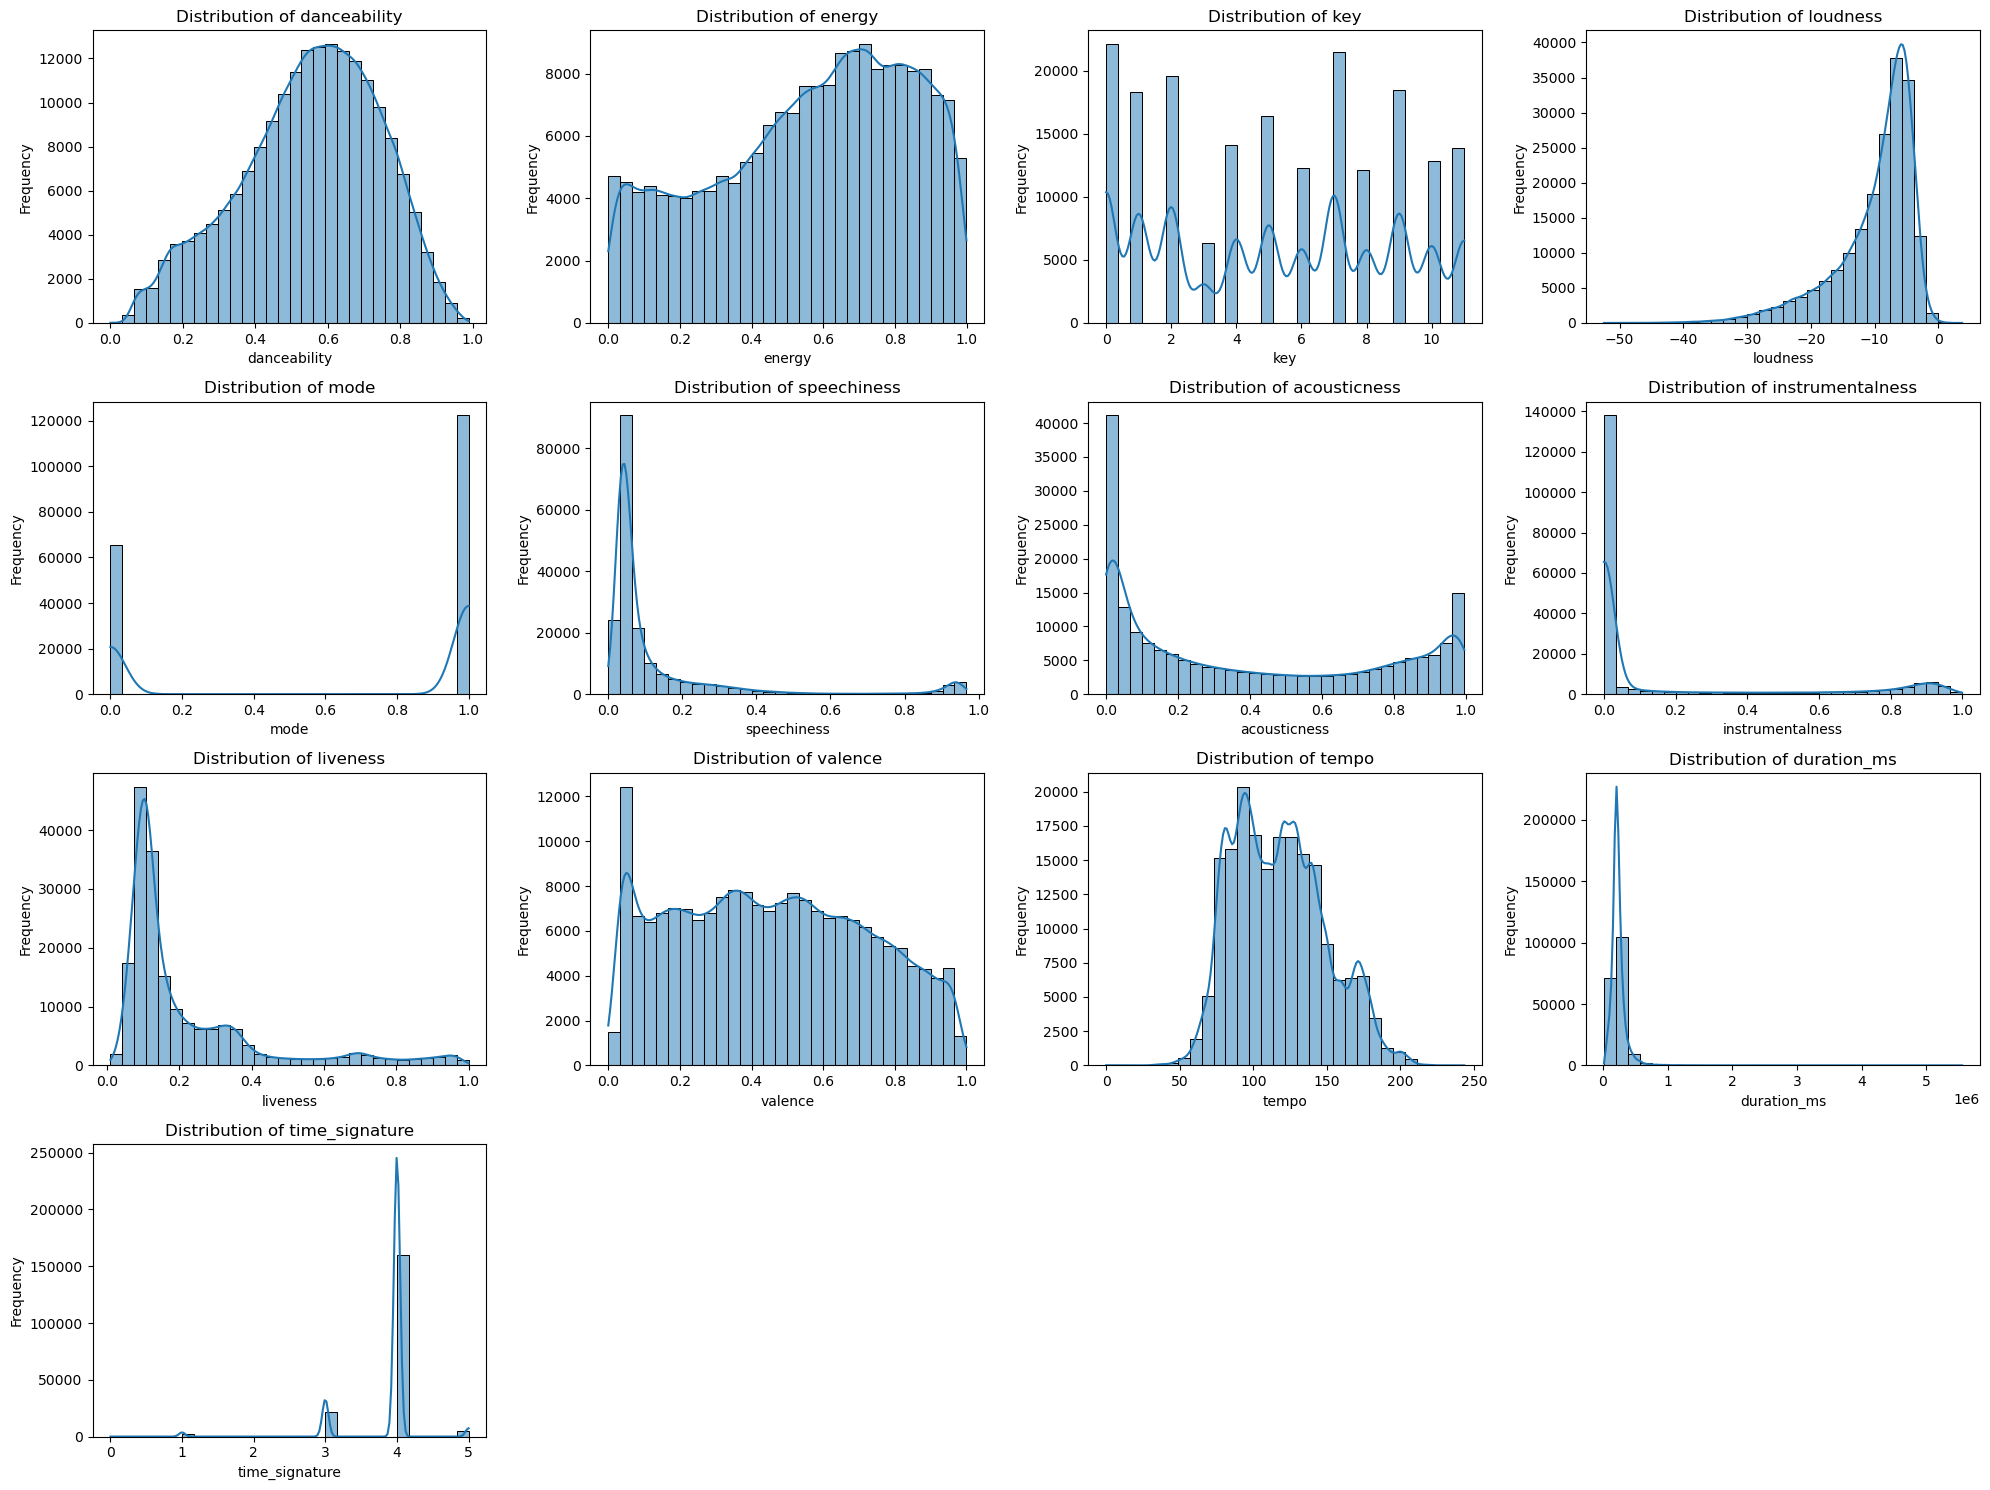

In [12]:
fig, axes = plt.subplots(4, 4, figsize=(20, 15)) # create 4x4 box for subplots

for i, col in enumerate(columns_selected):
    row = i // 4
    col_idx = i % 4
    sns.histplot(tracks_df[col], kde=True, bins=30, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Distribution of {col}')
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('Frequency')

# hide some subplots that we dont use
for i in range(len(columns_selected), 16):
    row = i // 4
    col_idx = i % 4
    axes[row, col_idx].set_visible(False)

plt.tight_layout()
plt.show()

* In the following plot, each dot represents a sample.

D:\anacoda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


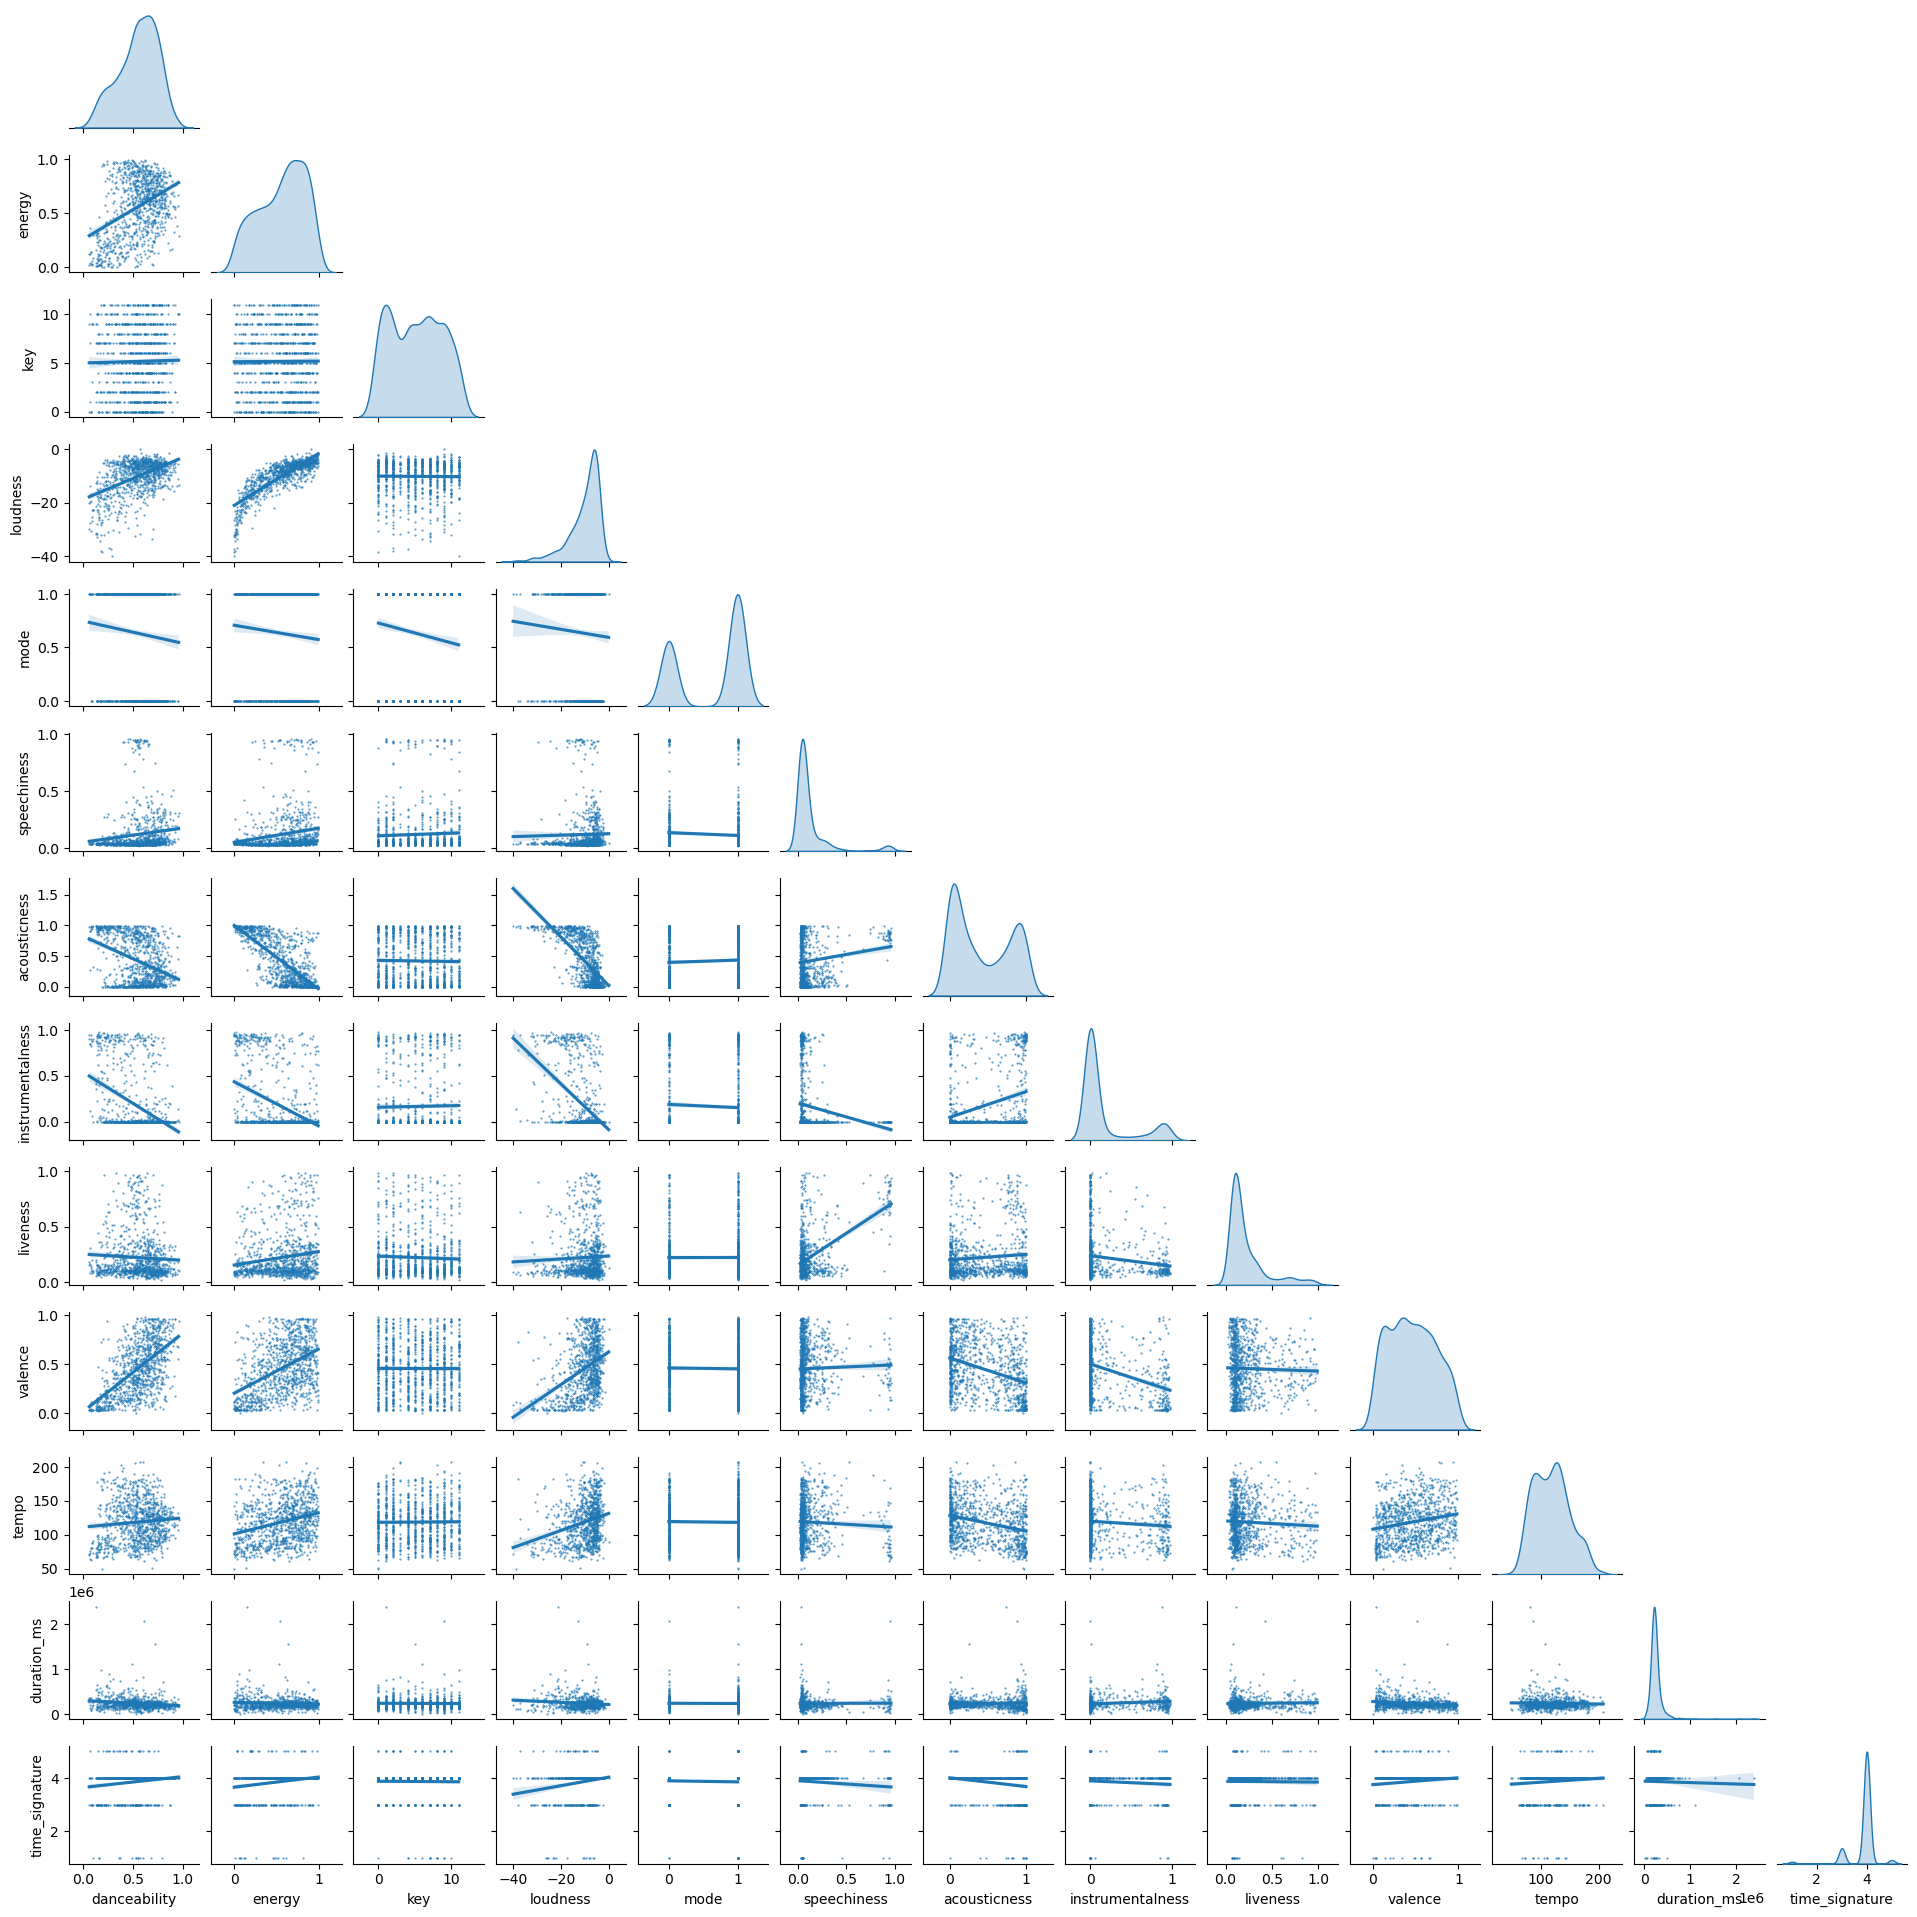

In [12]:
#Due to the large volume of data, I will take an even smaller sample to print this specific diagram. 
# Selecting a random sample from the selected DataFrame

dataset_col_sel_minisample = dataset_col_sel.sample(n=1000, random_state=42)

_ = sns.pairplot(dataset_col_sel_minisample, kind="reg", diag_kind="kde",
                 height=1.5, corner=True,
                 plot_kws={'scatter_kws': {'s': 0.25}})

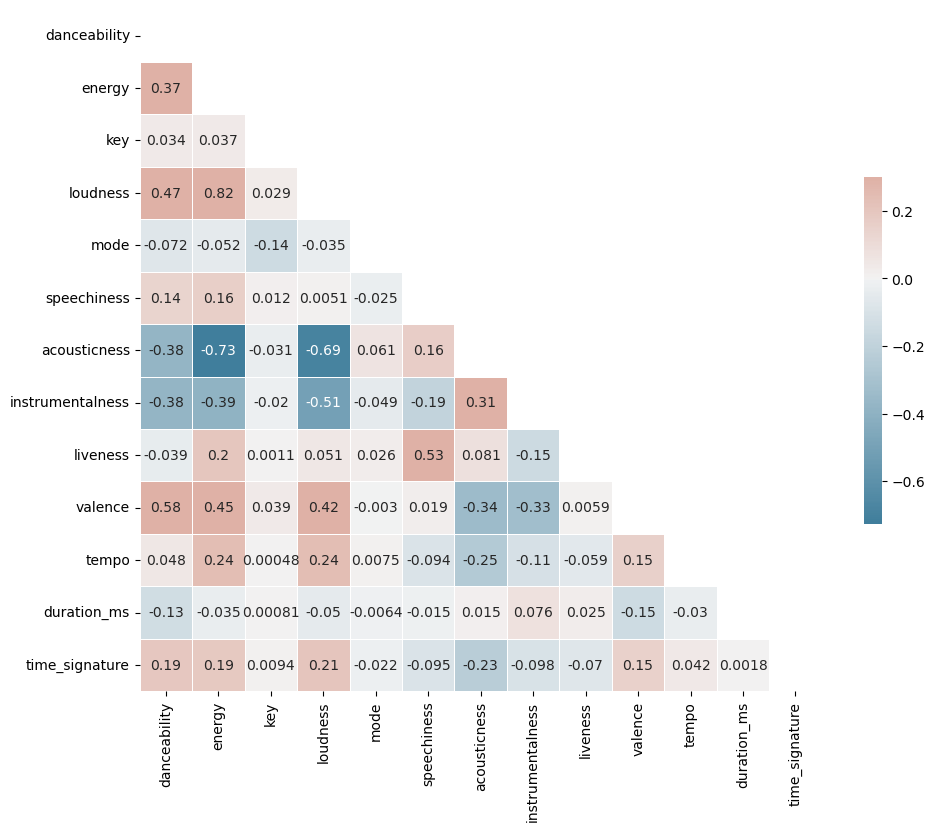

In [13]:
# Creating a linear correlation plot 
 
# Calculate the correlation matrix
corr = dataset_col_sel.corr()
 
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
 
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
 
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
 
plt.show()


## Insights and Observations from Data Exploration



### Distribution of Features
The descriptive statistics and histograms for each selected feature (`danceability`, `energy`, `key`, `loudness`, `mode`, `speechiness`, `acousticness`, `instrumentalness`, `liveness`, `valence`, `tempo`, `duration_ms`, `time_signature`) provide a broad understanding of their distributions across the dataset. Features like `danceability`, `energy`, and `valence` have relatively high mean values, suggesting that a significant portion of tracks in the dataset might be upbeat and energetic.


The skewness and kurtosis of each feature provide insights into the shape of their distribution across the dataset. Below is an analysis for each variable:

### Danceability
- **Skewness**: -0.359372 (slightly left-skewed)
- **Kurtosis**: -0.469627 (lighter tails than a normal distribution)
- Danceability scores are moderately left-skewed, indicating a slight preference for more danceable tracks in the dataset.

### Energy
- **Skewness**: -0.378782 (slightly left-skewed)
- **Kurtosis**: -0.915445 (lighter tails)
- Energy levels are also slightly left-skewed, suggesting a tendency towards more energetic tracks.

### Key
- **Skewness**: 0.012184 (approximately symmetrical)
- **Kurtosis**: -1.286157 (lighter tails)
- The key of a track is symmetrically distributed, indicating a uniform representation across all musical keys.

### Loudness
- **Skewness**: -1.540189 (significantly left-skewed)
- **Kurtosis**: 2.583484 (heavier tails)
- Loudness is highly left-skewed with a heavy-tailed distribution, meaning there are tracks with extremely low loudness values.

### Mode
- **Skewness**: -0.633657 (moderately left-skewed)
- **Kurtosis**: -1.598495 (lighter tails)
- Mode is moderately left-skewed, with major keys (mode=1) being more common.

### Speechiness
- **Skewness**: 3.081399 (highly right-skewed)
- **Kurtosis**: 9.023068 (very heavy tails)
- Speechiness is highly right-skewed, indicating many tracks have low speechiness with some outliers having very high speechiness.

### Acousticness
- **Skewness**: 0.413624 (slightly right-skewed)
- **Kurtosis**: -1.421149 (lighter tails)
- Acousticness has a slight right skew, suggesting a small number of tracks with high acousticness.

### Instrumentalness
- **Skewness**: 1.671366 (right-skewed)
- **Kurtosis**: 1.034935 (slightly heavier tails)
- Instrumentalness is right-skewed, indicating that while most tracks have low instrumentalness, there are outliers with high values.

### Liveness
- **Skewness**: 1.994580 (right-skewed)
- **Kurtosis**: 3.359276 (heavier tails)
- Liveness is highly right-skewed, with a heavier tail distribution, showing that most tracks are not live recordings.

### Valence
- **Skewness**: 0.131307 (approximately symmetrical)
- **Kurtosis**: -1.057574 (lighter tails)
- Valence is fairly symmetrically distributed with lighter tails, indicating a balance of tracks across the happiness spectrum.

### Tempo
- **Skewness**: 0.395383 (slightly right-skewed)
- **Kurtosis**: -0.473968 (lighter tails)
- Tempo shows a slight right skewness, suggesting a variation in track tempos with some faster tracks.

### Duration_ms
- **Skewness**: 9.608432 (highly right-skewed)
- **Kurtosis**: 226.803540 (extremely heavy tails)
- Duration_ms is highly right-skewed with very heavy tails, indicating a wide range of track lengths with some very long tracks.

### Time Signature
- **Skewness**: -2.963544 (highly left-skewed)
- **Kurtosis**: 14.504521 (extremely heavy tails)
- Time signature is highly left-skewed with extremely heavy tails, suggesting a strong preference for common time signatures (e.g., 4/4), with few tracks having more uncommon time signatures.

Overall, these characteristics point to a dataset with a diverse range of music tracks, each with unique audio features that define their musical style and listening experience.



### Correlations and Pairwise Relationships
The correlation heatmap adds depth to our understanding of the pairwise relationships between features. Notably:
- `Danceability` and `energy` show a moderate positive correlation with `valence`, suggesting that more danceable and energetic tracks tend to be perceived as happier.
- There is a strong negative correlation between `acousticness` and `energy`, indicating that tracks with a higher degree of acousticness tend to have lower energy levels.
- A significant negative correlation between `acousticness` and `loudness` implies that more acoustic tracks are generally quieter.
- `Valence` shows negative correlations with `acousticness` and `instrumentalness`, which may suggest that tracks with higher acoustic or instrumental content could be perceived as less happy.

### Key Observations
- Certain features demonstrate more significant relationships with `valence`. For example, `danceability` and `energy` are positively correlated, while `acousticness` and `instrumentalness` are negatively correlated with `valence`.
- Features such as `key`, `mode`, and `time_signature` have weaker correlations with `valence`, indicating that their impact on the perceived happiness of a track might be less straightforward.

### Challenges and Considerations
- The variability in features like `duration_ms` and `loudness` could influence model performance, highlighting the need for feature normalization or standardization in predictive modeling.
- Categorical variables (`key`, `mode`) require encoding to be effectively used in correlation analyses and predictive modeling.


#### 

##  Linear Regression

* We start off with fitting a Linear Regression model.


In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define all possible predictors in a list
predictors = ['danceability', 'energy', 'key', 'loudness', 
              'speechiness', 'acousticness', 'instrumentalness', 
              'liveness', 'tempo', 'duration_ms']

# Start with no predictors
best_predictors = []

# Track the best AIC
best_aic = float('inf')

# DataFrame to work with
df = dataset_col_sel

# Flag to indicate if we should keep adding variables
adding = True

while adding:
    adding = False
    for predictor in predictors:
        # Try adding the predictor to the current best predictors
        formula = f'valence ~ {" + ".join(best_predictors + [predictor])}'
        model = smf.ols(formula, data=df).fit()
        
        # Check if the AIC improved
        if model.aic < best_aic:
            best_aic = model.aic
            best_predictor = predictor
            adding = True
    
    if adding:
        # If AIC improved, update the best predictors list and remove the predictor from consideration
        best_predictors.append(best_predictor)
        predictors.remove(best_predictor)
        print(f'Added {best_predictor}, AIC: {best_aic}')

# Once we can no longer improve AIC by adding more predictors, we fit the final model
final_formula = f'valence ~ {" + ".join(best_predictors)}'
final_model = smf.ols(final_formula, data=df).fit()

print(final_model.summary())


Added danceability, AIC: -40955.95459845796
Added energy, AIC: -60252.70812031912
Added speechiness, AIC: -62926.0122966746
Added acousticness, AIC: -66618.22102452646
Added duration_ms, AIC: -68252.17256440531
Added tempo, AIC: -69545.67043949821
Added loudness, AIC: -70973.65317850542
Added instrumentalness, AIC: -73289.29217108461
Added key, AIC: -73348.62948752398
Added liveness, AIC: -73349.18583254569
                            OLS Regression Results                            
Dep. Variable:                valence   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 1.461e+04
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        23:56:07   Log-Likelihood:                 36686.
No. Observations:              187945   AIC:                        -7.335e+04
Df Residuals:                  18793

- we did stepwise regression process where variables are added one by one to a linear regression model based on their impact on the Akaike Information Criterion (AIC). The AIC is a measure of the relative quality of statistical models for a given set of data. As each variable is added, we look for a decrease in the AIC value, which indicates an improvement in the model's fit to the data.

- From the AIC values listed, each addition of a variable has led to a lower AIC, suggesting that each subsequent model fits the data better than the previous one. The final model includes ten variables: danceability, energy, speechiness, acousticness, duration_ms, tempo, loudness, instrumentalness, key, and liveness.

- The OLS (Ordinary Least Squares) regression results show that most of the included features are statistically significant predictors of valence, as indicated by their p-values being less than 0.05. Danceability and energy have the largest positive coefficients, indicating a strong positive relationship with valence. Conversely, speechiness and instrumentalness have a negative relationship with valence.

- The model's R-squared value is 0.437, which means that about 43.7% of the variability in valence can be explained by the model. While this is a reasonable amount of variance explained, it also suggests that there is room for improvement, as more than half of the variability is unaccounted for.

- The model diagnostics indicate a relatively good fit, with some potential issues. The Durbin-Watson statistic is close to 2, which suggests there is no major problem with autocorrelation. The condition number is large, indicating potential multicollinearity, which means some predictor variables might be highly correlated with each other.

In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.ols('valence ~ danceability + energy + key + loudness + \
                speechiness + acousticness + instrumentalness  + liveness+\
                tempo + duration_ms ', data=dataset_col_sel).fit()


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                valence   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 1.461e+04
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        23:56:15   Log-Likelihood:                 36686.
No. Observations:              187945   AIC:                        -7.335e+04
Df Residuals:                  187934   BIC:                        -7.324e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3423      0.005  

### The variable 'liveness' has a p-value of 0.110, which means it is not statistically significant. Therefore, we will remove it from the model.

In [15]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model_2 = smf.ols('valence ~ danceability + energy + key + loudness + \
                speechiness + acousticness + instrumentalness  + \
                tempo + duration_ms ', data=dataset_col_sel).fit()


print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                valence   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 1.623e+04
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        23:56:18   Log-Likelihood:                 36684.
No. Observations:              187945   AIC:                        -7.335e+04
Df Residuals:                  187935   BIC:                        -7.325e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3420      0.005  

In [16]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import pandas as pd


X = dataset_col_sel[['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',  'tempo', 'duration_ms']]
y = dataset_col_sel['valence']

# standarize the coefficients
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Adding a constant column for the constant term in regression analysis
X_scaled = sm.add_constant(X_scaled)

# Creating the OLS model with the standardized data
model_2 = sm.OLS(y, X_scaled).fit()


print(model_2.summary())


coefficients = pd.DataFrame(model_2.params, columns=['Coefficient'])
p_values = pd.DataFrame(model_2.pvalues, columns=['p-value'])
results = pd.concat([coefficients, p_values], axis=1)
results['abs_coefficient'] = results['Coefficient'].abs()
results_sorted = results.sort_values('abs_coefficient', ascending=False)

print(results_sorted)


                            OLS Regression Results                            
Dep. Variable:                valence   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                 1.623e+04
Date:                Sun, 03 Mar 2024   Prob (F-statistic):               0.00
Time:                        23:56:23   Log-Likelihood:                 36684.
No. Observations:              187945   AIC:                        -7.335e+04
Df Residuals:                  187935   BIC:                        -7.325e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4550      0.000    990.905      0.0

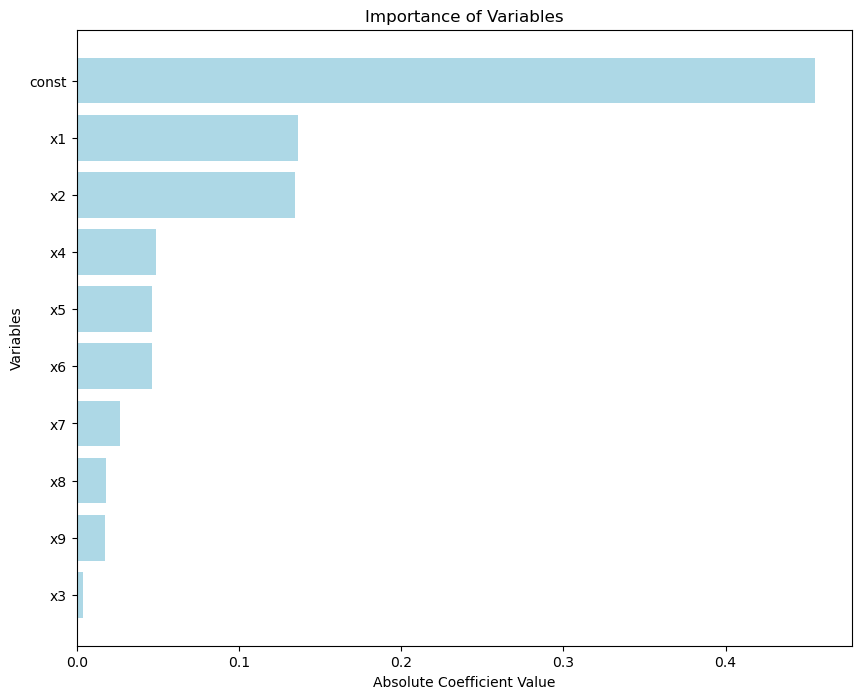

In [17]:
import matplotlib.pyplot as plt


variable_names = results_sorted.index
coefficients = results_sorted['abs_coefficient']

# create the barplot
plt.figure(figsize=(10, 8))
plt.barh(variable_names, coefficients, color='lightblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Variables')
plt.title('Importance of Variables')
plt.gca().invert_yaxis() 
plt.show()


## Interpretation of OLS Regression Coefficients

The OLS Regression Results provide insights into the impact of various audio features on the valence (measure of musical positivity) of Spotify tracks. Below is the interpretation of the coefficients for each feature, highlighting their standardized effect on valence and arranged by their importance:

1. **Danceability**: 
    - **Coefficient:** `0.7143`
    - **Interpretation:** Danceability has a positive impact on valence, indicating that as danceability increases, the perceived positivity of a track also increases. Specifically, this implies that for each additional unit increase in danceability, the valence of the song increases by approximately 0.7143 units, assuming all other numeric independent variables remain constant.

2. **Energy**: 
    - **Coefficient:** `0.4957`
    - **Interpretation:** Energy significantly affects valence positively, indicating that as energy increases, the perceived positivity of a track also increases. Specifically, for each unit increase in energy, the valence increases by approximately 0.4957 units, assuming all other variables are held constant.

3. **Speechiness**: 
    - **Coefficient:** `-0.2323`
    - **Interpretation:** Speechiness indicates a negative relationship with valence, meaning that as speechiness increases, valence decreases. Specifically, for each unit increase in speechiness, the valence of the track decreases by approximately 0.2323 units, assuming other variables are constant.

4. **Acousticness**: 
    - **Coefficient:** `0.1275`
    - **Interpretation:** Acousticness shows a positive relationship with valence, indicating that tracks with higher acousticness tend to have higher valence. Specifically, for each unit increase in acousticness, the valence increases by approximately 0.1275 units, with other factors remaining constant.

5. **Instrumentalness**: 
    - **Coefficient:** `-0.0851`
    - **Interpretation:** Instrumentalness implies a negative relationship with valence, suggesting that as instrumentalness increases, the perceived positivity of a track decreases. Specifically, for each unit increase in instrumentalness, the valence decreases by approximately 0.0851 units, assuming constancy in other variables.

6. **Loudness**: 
    - **Coefficient:** `-0.0078`
    - **Interpretation:** Loudness demonstrates a slight negative impact on valence, suggesting that louder tracks might be perceived as slightly less positive. Specifically, for each unit increase in loudness, the valence decreases by approximately 0.0078 units, with other variables held constant.

7. **Tempo**: 
    - **Coefficient:** `0.0006`
    - **Interpretation:** Tempo indicates that faster tracks are slightly associated with higher valence, although the impact is modest. Specifically, for each unit increase in tempo, the valence increases by approximately 0.0006 units, assuming all other factors are constant.

8. **Duration_ms**: 
    - **Coefficient:** `-1.388e-07`
    - **Interpretation:** Duration_ms suggests that longer tracks may slightly decrease in valence, but the effect is minimal. Specifically, for each unit increase in duration (measured in milliseconds), the valence decreases by approximately 0.0000001388 units, with other variables held constant.

9. **Key**: 
    - **Coefficient:** `0.0010`
    - **Interpretation:** The musical key has a very slight positive effect on the perceived positivity of a track. Specifically, for each unit increase in the key, the valence increases by approximately 0.0010 units, assuming the constancy of other factors.

The **Intercept** of `-0.3420` represents the baseline level of valence when all other predictors are at zero. This is more of a theoretical value, as it's improbable for all predictors to be zero in practice.




## Regression Analysis Conclusions

The regression results indicate adjustments made after removing the 'liveness' feature due to its lack of statistical significance (p-value > 0.05). The model has an R-squared value of 0.437, suggesting that approximately 43.7% of the variability in 'valence' is explained by the included predictors.

### Key Takeaways for Each Feature : 
### standarized coefficeints in order to comparing the relative importance of each predictor in the model 


- **Danceability (x1):** Positive coefficient (0.1366), indicating a strong relationship where higher danceability is associated with higher valence.
- **Energy (x2):** Also shows a positive effect on valence with a coefficient of 0.1348.
- **Key (x3):** Small but statistically significant positive coefficient (0.0036), suggesting a slight effect on valence.
- **Loudness (x4):** Negative coefficient (-0.0491), indicating that increased loudness is associated with decreased valence.
- **Speechiness (x5):** Negative coefficient (-0.0466), suggesting that tracks with more spoken words tend to have lower valence.
- **Acousticness (x6):** Positively related to valence with a coefficient of 0.0461.
- **Instrumentalness (x7):** Negative effect on valence (-0.0269), indicating that tracks with more instrumental content tend to have lower valence.
- **Tempo (x8):** Positive coefficient (0.0181), suggesting faster songs are associated with higher valence.
- **Duration (x9):** Negative coefficient (-0.0177), indicating longer tracks are associated with lower valence.

### Model Diagnostics:

- The **Durbin-Watson** statistic around 1.691 suggests no major issues with autocorrelation.
- The **Omnibus** and **Jarque-Bera** tests may indicate non-normality in residuals, though this concern is mitigated by the large sample size.
- Potential **multicollinearity** is suggested by a previously high condition number, common in datasets with many correlated predictors.

-However, for the linear regression model to provide reliable predictions, certain assumptions must be met:

Linearity: The relationship between the independent variables (predictors) and the dependent variable (outcome) is assumed to be linear. This means that a change in any independent variable will lead to a proportional change in the dependent variable.

Independence: Observations are assumed to be independent of each other. In other words, the observations should not be influenced by each other.

Homoscedasticity: The residuals (the differences between the observed values and the values predicted by the model) should have constant variance at every level of the independent variable. When the variance of residuals is non-constant, the phenomenon is known as heteroscedasticity.

Normal Distribution of Residuals: For any fixed value of the independent variables, the residuals are assumed to be normally distributed. This assumption allows for the generation of confidence intervals and hypothesis tests concerning the coefficients.

No or Little Multicollinearity: Multicollinearity occurs when independent variables in the model are correlated. This condition can cause instability in the coefficient estimates, making it difficult to interpret the effects of independent variables. Ideally, the model should have little to no multicollinearity among the predictors.

No Auto-correlation: This assumption is particularly relevant for time-series data. Auto-correlation occurs when the residuals are not independent from each other.

In our case no every assumption is met because of the nature of the data , and we try to make transformation to the model but the situation did not improve.

### Conclusion:

This model offers insights into the factors contributing to a song's valence on Spotify, with danceability and energy showing the strongest positive effects, and speechiness and instrumentalness showing notable negative effects. The model's explanatory power could potentially be improved with further analysis exploring interactions or non-linear effects, and by incorporating additional data or features.


# 

#

## <font color="blue">  Q2: Predict Valence </font>


Use Machine Learning techniques to predict valence based on track features:
You will use at least three different methods. For each methods you should ensure that you tune your hyperparameters as best as you can.
Once you identify the best method and hyperparameters, explain, to the extent that is possible, which features influence the valence metric.
You will evaluate your predictions on a holdout testing dataset that will be provided to you. Your evaluation and the value of the MAE on the holdout testing dataset must be included at the end of your submission.

####

* We split the sample into a train and a test dataset splits by  to 0.2.

* This is a way to emulate a real situation where predictions are performed on an unknown target, and we don't want our analysis and decisions to be biased by our knowledge of the test data.

#### Mean Absolute Error (MAE) Evaluation

The **Mean Absolute Error (MAE)** is a crucial metric utilized for assessing the accuracy of a prediction model. It represents the average of the absolute differences between the predicted and actual values. Essentially, it measures the average magnitude of errors in a set of predictions, without considering their direction. A lower MAE value indicates higher accuracy in the predictions made by the model.

#### Importance of Generalization in Machine Learning

In the realm of **machine learning**, ensuring that our model performs effectively not just on the training data but also on unseen future data is paramount. This concept, known as *generalization*, is fundamental for the model's applicability in real-world scenarios. To facilitate this, data is split into two distinct sets:
- **Training set**: Used for learning the predictive patterns.
- **Test set**: Serves to evaluate how the model performs on data it hasn't encountered during training.

This division ensures that the model's performance is tested in a realistic scenario, mirroring its future applications on unknown data.

#### Data Splitting Strategy

Adopting a data splitting strategy, where typically **20% of the data is reserved for testing** ("splits by to 0.2"), is a widely accepted practice. This approach helps in evaluating the model's performance more accurately, ensuring that it is tested against a representative sample of the overall data. It mitigates the risk of **overfitting**—where a model might perform exceptionally well on the training data but fails to predict accurately on new, unseen data.

#### Evaluating MAE on Training and Test Sets

- **Training Set MAE**: Reflects how well the model has learned from the training data. A lower MAE here suggests effective learning and good performance on the training set.
- **Test Set MAE**: More critical, as it indicates the model's ability to generalize its predictions to unseen data. A low MAE in this context signifies a model that can reliably predict outcomes in real-world applications.

The goal is to achieve a model that demonstrates low MAE values across both sets, indicating both high accuracy and strong generalization capabilities. Significant disparities in MAE between the training and test sets may signal overfitting, highlighting a model's struggle to adapt to new data effectively.


#


### Following code overview : 


### Data Splitting
We split the data into a training set and a testing set (test set) with a ratio of 80% for training and 20% for testing, to evaluate the performance of the models on unknown data.

### Model Training
We train various machine learning models, such as Linear Regression, Decision Tree, Random Forest, Gradient Boosting, XGBoost, LightGBM, and LASSO, on the training set.

### Hyperparameter Tuning
We optimize the hyperparameters for each model to improve their performance.

### Predictions and Evaluation
We make predictions on the test set and evaluate the accuracy of the models using the Mean Absolute Error (MAE). This allows us to understand how well the model predicts "valence" values on new, unknown data.

### Model Comparison
We compare the performance of the various models based on MAE to determine which model performs best for this particular prediction task.

### Interpretation
We analyze which features most significantly affect the "valence" variable, based on the best-performing model.


#

## Hyperparameter Definition to Adjust Model Behavior and Improve Performance:

1. **Linear Regression**
   - A basic statistical model that attempts to predict a dependent variable (y) as a linear function of one or more predictors (X). It is used for predicting continuous values.

2. **Decision Tree Regressor**
   - A model that uses tree structures to make predictions. Each "branch" of the tree represents a choice between two or more options, leading to different outcomes.
- max_depth: 10 - This parameter indicates the maximum depth of the tree. A depth of 10 means that the tree is allowed to split up to ten levels down. This depth can help control overfitting by not allowing the tree to grow too deep and complex, but still deep enough to capture the underlying patterns in the data.
- min_samples_leaf: 4 - This parameter specifies the minimum number of samples required to be at a leaf node. Setting it to 4 means that each leaf node must represent at least four samples. This constraint ensures that the model does not make decisions based on too little data, which can help improve the model's generalization ability and prevent overfitting.
- min_samples_split: 10 - This parameter determines the minimum number of samples required to split an internal node. A value of 10 means that a node must represent at least ten samples for it to be considered for a split. This setting helps in preventing the model from making splits that are too specific, which can lead to overfitting.

These hyperparameters were chosen as the best combination by the Grid Search process to minimize the Mean Absolute Error (MAE) on the cross-validation sets. The goal was to find a balance between the model's ability to learn from the training data and its generalization to unseen data, resulting in an optimized performance as indicated by the lowest MAE obtained.

3. **Random Forest Regressor**
- After review, we decided not to run a grid search for the Random Forest Regressor as it runs for too long and does not offer a significant improvement of the MAE. So we search and we found that this hyperparameters gine us a low MAE .
   - `n_estimators=50`: Sets the number of trees in the random forest to 50. A smaller number of trees can reduce training time and model complexity while still maintaining good performance.
   - `max_depth=10`: limits the depth of each tree to avoid overfitting.
   - `n_jobs=-1`: Uses all available processor cores for training, speeding up the process.

4. **Gradient Boosting Regressor**
- After review, we decided not to run a grid search for the Gradient Boosting Regressor as it runs for too long and does not offer a significant improvement of the MAE. 
   - A boosting learning technique that creates a prediction model in the form of an ensemble of simple models, usually decision trees. It improves the model's predictions by adding trees that correct the errors of previous ones.
   - Default hyperparameters in the Scikit-learn library for Gradient Boosting Regressor include:
     - `loss='squared_error'`: The loss function to be minimized in the training process. The default value corresponds to the square of the mean squared error.
     - `learning_rate=0.1`: The learning rate defines how quickly the model adapts to the problem. The default value is 0.1.
     - `n_estimators=100`: The number of trees to be added to the model. The default value is 100.
     - `max_depth=3`: The maximum depth of the individual trees. The default value is 3.
     - `min_samples_split=2`: The minimum number of samples required to split an internal node. The default value is 2.
     - `min_samples_leaf=1`: The minimum number of samples required to be at a leaf node. The default value is 1.
     - `max_features='auto'`: The number of features to consider when looking for the best split. The default value means that all features will be considered.
     - `random_state=None`: Defines the seed for the generation of random numbers. If not set, the value is None.
     

5. **XGBoost Regressor**
   - An optimized implementation of Gradient Boosting designed for increased speed and efficiency. XGBoost provides tools for managing large volumes of data more effectively.

The selection of hyperparameters in the provided XGBoost model was conducted through a process known as Grid Search, using the GridSearchCV tool from sklearn.model_selection. Here's a breakdown of how the optimal hyperparameters were chosen:

- Grid Search Methodology: Grid Search works by exhaustively searching through a manually specified subset of the hyperparameter space of a learning algorithm. For each combination of hyperparameters, the model is trained, and its performance is evaluated using cross-validation.

- Cross-Validation: In this case, 5-fold cross-validation was used. This means the training data set was split into 5 parts, with the model being trained on 4 parts and validated on the 1 remaining part. This process is repeated 5 times so that each part is used as the validation set exactly once. Cross-validation helps in assessing how the model's predictions generalize to an independent dataset.

- Hyperparameter Space: The hyperparameters and their respective ranges specified in the param_grid are as follows:

    - n_estimators: [50, 100, 200, 300, 400] - This represents the number of trees in the forest. More trees can lead to more accurate predictions but can also increase the computation time.
    - learning_rate: [0.05, 0.1] - This is the step size shrinkage used to prevent overfitting. It determines the impact of each tree on the final outcome.
     - max_depth: [3, 5, 7, 9] - This indicates the maximum depth of each tree. Deeper trees can model more complex relationships but may also lead to overfitting.
     - colsample_bytree: [0.7, 1.0] - This parameter is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
     - subsample: [0.7, 1.0] - This is the subsample ratio of the training instances. This parameter can prevent overfitting by making the model more conservative.
     - Evaluation and Selection: The performance of each model configuration (combination of hyperparameters) was evaluated using the negative mean absolute error (MAE). The configuration that resulted in the highest performance (or in this case, the least negative value, which corresponds to the lowest MAE) was selected as the best set of hyperparameters.

Resulting Best Hyperparameters: The best hyperparameters chosen by the Grid Search were:

        - colsample_bytree: 1.0
        - learning_rate: 0.05
        - max_depth: 9
        - n_estimators: 400
        - subsample: 0.7
These parameters were selected because they resulted in the lowest MAE during the cross-validation process, indicating that they are likely to provide the best generalization performance on unseen data.

6. **LightGBM Regressor**
   - A Gradient Boosting implementation that uses tree-based algorithms designed to be more efficient, requiring less memory and training time, especially on large data sets.
   
In this LightGBM model setup, the selection of hyperparameters was guided by the best parameters obtained from a previously conducted Grid Search for an XGBoost model.The way of how each hyperparameter was chosen based on the XGBoost model's results and how they were adapted for LightGBM:

n_estimators: This parameter specifies the number of boosting stages the model will go through, which directly impacts the model's complexity and ability to learn from the data. For the LightGBM model, we adopted the n_estimators value of 400 directly from the XGBoost's best parameters. This large number of estimators was chosen to potentially allow the model to capture complex patterns in the data, similar to how it was determined beneficial for the XGBoost model.

learning_rate: The learning rate controls the rate at which the model is allowed to 'learn' at each step. A lower value typically means the model needs more trees (estimators) to converge on a solution but can lead to a more robust model by reducing the risk of overfitting. We used a learning rate of 0.05, mirroring the optimal value found for XGBoost, aiming for a balance between learning speed and the model's ability to generalize.

max_depth vs. num_leaves: Unlike XGBoost, which uses max_depth to control the depth of each tree directly, LightGBM uses num_leaves to manage the complexity of the tree models. There isn't a direct translation between max_depth and num_leaves, but a common heuristic is that num_leaves should be less than 2^max_depth. Based on the XGBoost max_depth of 9, we set num_leaves to 2^9, simplifying the conversion and attempting to align the model's complexity with what was found optimal for XGBoost.

colsample_bytree and subsample: These parameters control the fraction of features (columns) and the fraction of the data (rows), respectively, that are used to build each tree. A value of 1.0 for colsample_bytree indicates that all features are used. For subsample, a value of 0.7 means that 70% of the data samples are used for each tree, introducing randomness that can help in making the model more robust. These values were directly taken from the XGBoost model's best parameters, aiming to incorporate the same level of feature and data sampling into the LightGBM model.

By adopting these hyperparameters from the XGBoost model, the intent was to leverage the insights gained from the extensive Grid Search optimization process for XGBoost, applying them to LightGBM in the hope of achieving similar or improved performance without conducting another time-consuming Grid Search for LightGBM. However, it's important to note that due to differences in how these two models work, further adjustments and optimizations might be necessary to fully optimize the LightGBM model's performance on the given dataset, but our pc is weak and can't finish the search. 


#### Setting hyperparameters in such a way is a good approach because it allows us to customize the behavior of each model to the specific data, aiming to optimize the accuracy of predictions while simultaneously reducing the risk of overfitting.


In [18]:
from sklearn.model_selection import train_test_split

# Definition of the independent variables (X) and the dependent variable (y)
X = dataset_col_sel.drop(['valence'], axis=1)
y = dataset_col_sel['valence']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
from sklearn.metrics import median_absolute_error


y_pred = model.predict(X_train)

mae = median_absolute_error(y_train, y_pred)

print(f"MAE linear regression on training set: {mae:.4f}")


MAE linear regression on training set: 0.1379


In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)


y_pred_lin_reg = lin_reg.predict(X_test)

#  MAE
mae_lin_reg = mean_absolute_error(y_test, y_pred_lin_reg)
print(f"MAE on test set (Linear Regression): {mae_lin_reg}")

MAE on test set (Linear Regression): 0.15890016255727535


(0.0, 1.0)

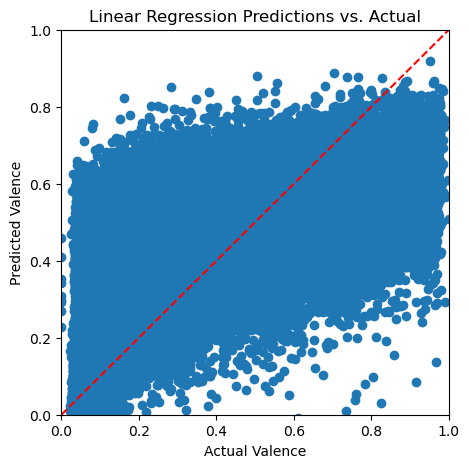

In [22]:

y_pred_test = model.predict(X_test)



fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_pred_test)  
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.title("Linear Regression Predictions vs. Actual")
plt.ylabel("Predicted Valence")
plt.xlabel("Actual Valence")
plt.xlim([0, 1])
plt.ylim([0, 1])


* The model learnt is far from being a good model making accurate predictions.

* This is obvious when looking at the plot above, where good predictions should lie on the red line.

## Decision Tree

In [59]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Creating the Decision Tree Regressor model
dt_reg = DecisionTreeRegressor(random_state=42)

# Defining the hyperparameter space for Grid Search
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at a leaf node
}

# Creating the GridSearchCV object
grid_search = GridSearchCV(estimator=dt_reg, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=2)

# Training the GridSearchCV object with the training set
grid_search.fit(X_train, y_train)

# Printing the best hyperparameters
print(f"Best parameters: {grid_search.best_params_}")

# Using the best model to make predictions on the test set
best_model = grid_search.best_estimator_
y_pred_dt = best_model.predict(X_test)

# Calculating and printing the Mean Absolute Error (MAE)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
print(f"MAE (Decision Tree with Grid Search): {mae_dt}")


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
MAE (Decision Tree with Grid Search): 0.15051584214289004


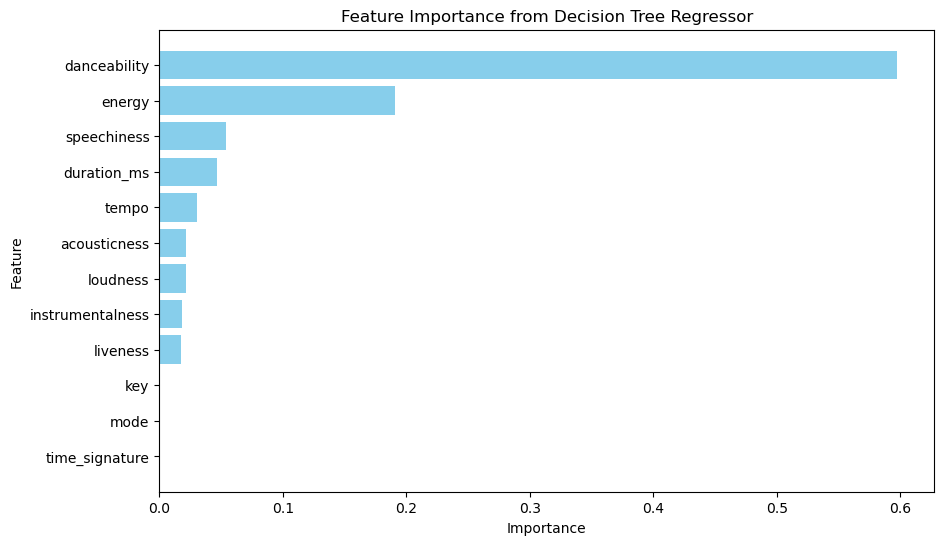

In [91]:
# Extracting feature importances from the best model
feature_importance = best_model.feature_importances_

# Normalizing the feature importances
feature_importance_normalized = feature_importance / np.sum(feature_importance)

# Creating a DataFrame for easier representation
features = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance_normalized})

# Sorting the DataFrame based on importance
features_sorted = features.sort_values(by='Importance', ascending=False)

# Creating the bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.barh(features_sorted['Feature'], features_sorted['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Decision Tree Regressor')
plt.gca().invert_yaxis()  # Inverting the order to show the most important feature first
plt.show()


## Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


rf_reg = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)

# Training the model with the training set
rf_reg.fit(X_train, y_train)

# Making predictions on the test set
y_pred_rf = rf_reg.predict(X_test)

#  MAE
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"MAE (Random Forest): {mae_rf}")


MAE (Random Forest): 0.1447602065374652


             Feature  Importance
0       danceability    0.579837
1             energy    0.190723
5        speechiness    0.055665
10       duration_ms    0.049044
9              tempo    0.031127
6       acousticness    0.025310
3           loudness    0.024347
7   instrumentalness    0.020324
8           liveness    0.020317
2                key    0.001489
4               mode    0.001464
11    time_signature    0.000354


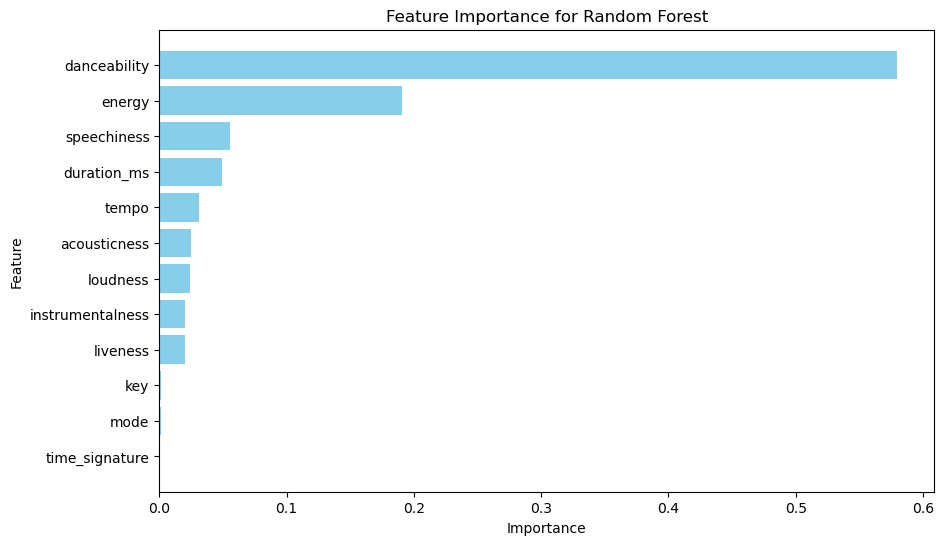

In [33]:
# Extracting the feature importances from the Random Forest model
feature_importance_rf = rf_reg.feature_importances_

# Creating a DataFrame for easier display
features_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance_rf})

# Sorting the features based on importance in descending order
features_sorted_rf = features_rf.sort_values(by='Importance', ascending=False)

# Printing the importances
print(features_sorted_rf)

# Creating the plot
plt.figure(figsize=(10, 6))
plt.barh(features_sorted_rf['Feature'], features_sorted_rf['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()


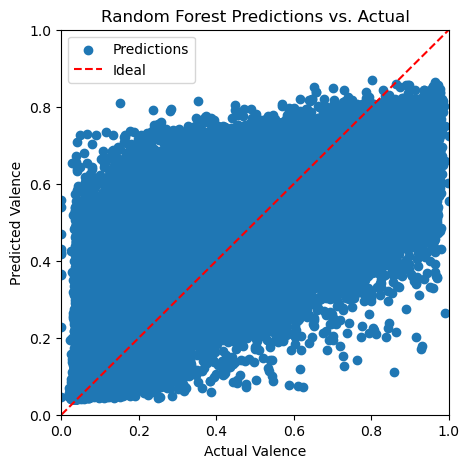

In [97]:
import matplotlib.pyplot as plt

# Assuming y_pred_rf is your predictions from the Random Forest model
# and y_test is the actual valence values from the testing set

# Create the scatter plot
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_pred_rf, label='Predictions')

# Plot the ideal line for comparison
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red", label='Ideal')

# Add titles and labels
plt.title("Random Forest Predictions vs. Actual")
plt.ylabel("Predicted Valence")
plt.xlabel("Actual Valence")

# Set the limits of x and y to be the same as in the linear regression plot
plt.xlim([0, 1])
plt.ylim([0, 1])

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()



## Gradient Boosting

In [62]:
from sklearn.ensemble import GradientBoostingRegressor

# Creating and training the model
gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred_gb = gb_reg.predict(X_test)

# Calculating the MAE
mae_gb = mean_absolute_error(y_test, y_pred_gb)
print(f"MAE (Gradient Boosting): {mae_gb}")

MAE (Gradient Boosting): 0.14705665232690485


             Feature  Importance
0       danceability    0.588296
1             energy    0.200517
5        speechiness    0.060629
10       duration_ms    0.041259
9              tempo    0.035975
8           liveness    0.024949
7   instrumentalness    0.018889
6       acousticness    0.016137
3           loudness    0.010215
4               mode    0.002055
2                key    0.001079
11    time_signature    0.000000


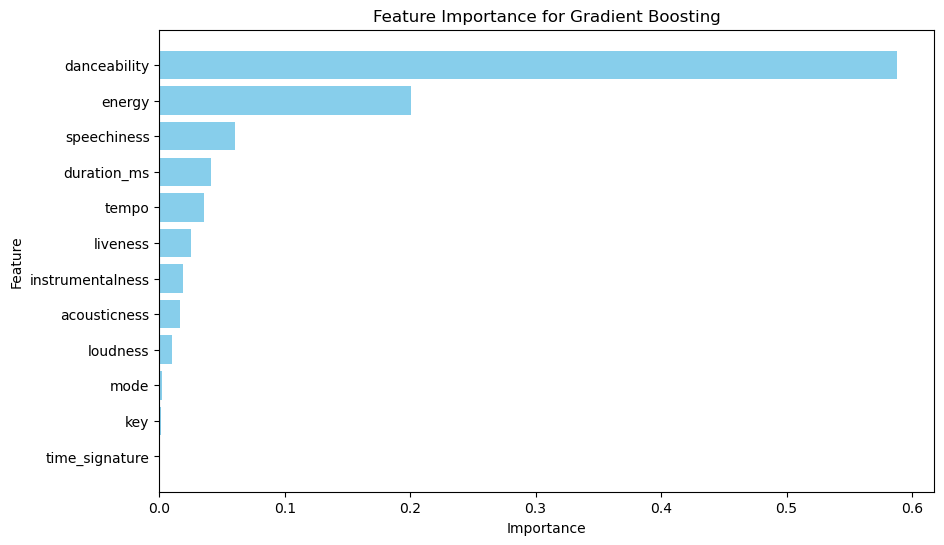

In [34]:
# Extracting the feature importances from the Gradient Boosting model
feature_importance_gb = gb_reg.feature_importances_

# Normalizing the feature importances (though they are already normalized in practice)
feature_importance_normalized_gb = feature_importance_gb / np.sum(feature_importance_gb)

# Creating a DataFrame for easier display
features_gb = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance_normalized_gb})

# Sorting the features based on importance in descending order
features_sorted_gb = features_gb.sort_values(by='Importance', ascending=False)

# Printing the normalized importances
print(features_sorted_gb)

# Creating the plot for feature importance
plt.figure(figsize=(10, 6))
plt.barh(features_sorted_gb['Feature'], features_sorted_gb['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Gradient Boosting')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()

## XGBoost

In [78]:
#!pip install xgboost
#!pip install lightgbm

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# Creating the XGBoost Regressor model
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Defining the hyperparameter space for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],  # Increased number of trees
    'learning_rate': [0.05, 0.1],  # Learning rate
    'max_depth': [3, 5, 7, 9],  # Increased depth of each tree
    'colsample_bytree': [0.7, 1.0],  # Subsample ratio of columns when constructing each tree
    'subsample': [0.7, 1.0]  # Subsample ratio of the training instance
}

# Creating the GridSearchCV object
grid_search2 = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

# Training the GridSearchCV object with the training set
grid_search2.fit(X_train, y_train)

# Printing the best hyperparameters
print(f"Best parameters: {grid_search2.best_params_}")

# Using the best model to make predictions on the test set
best_model2 = grid_search2.best_estimator_
y_pred_xgb = best_model2.predict(X_test)

# Calculating and printing the Mean Absolute Error (MAE)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"MAE (XGBoost with Grid Search): {mae_xgb}")


Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 400, 'subsample': 0.7}
MAE (XGBoost with Grid Search): 0.13305826031581477


Feature Importances:
             Feature  Importance
0       danceability    0.293514
1             energy    0.145153
5        speechiness    0.077397
10       duration_ms    0.071213
9              tempo    0.068251
7   instrumentalness    0.060312
6       acousticness    0.057784
3           loudness    0.056024
8           liveness    0.055633
4               mode    0.051357
11    time_signature    0.033083
2                key    0.030278


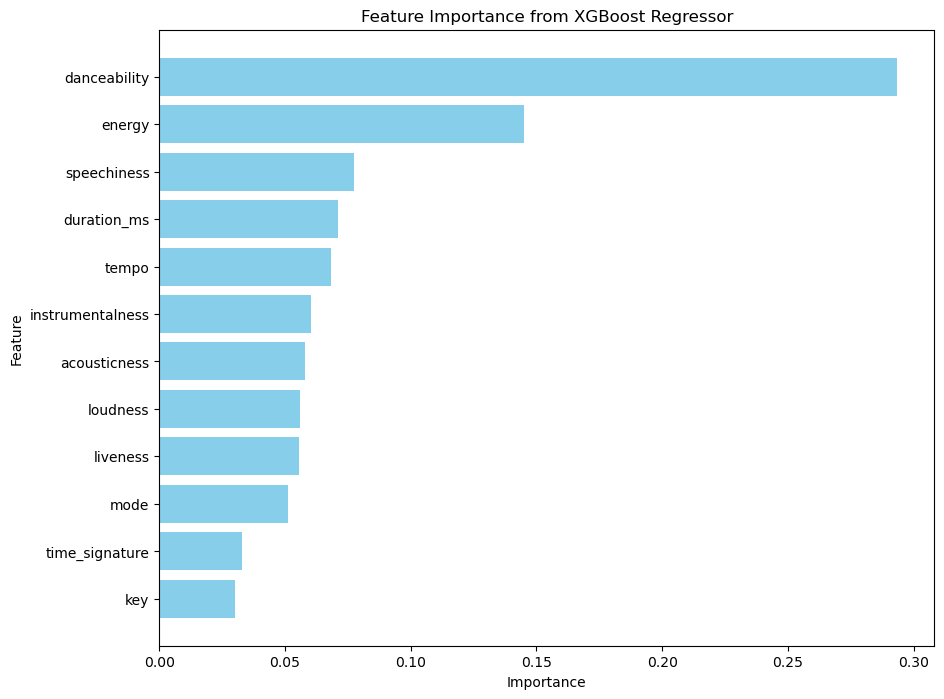

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

# Finding the importance of the features
feature_importances = best_model2.feature_importances_

# Creating a DataFrame for easier representation
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sorting the DataFrame based on importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Printing the feature importances
print("Feature Importances:")
print(features_df)

# Creating the barplot
plt.figure(figsize=(10, 8))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from XGBoost Regressor')
plt.gca().invert_yaxis()  # Inverting the order to show the most important feature first
plt.show()



## LightGBM

In [92]:
import lightgbm as lgb

# Since the 'max_depth' and 'n_estimators' were specifically optimized for XGBoost, 
# we will use these values as a reference. Note that LightGBM uses 'num_leaves' instead of 'max_depth',
# so a direct conversion is not straightforward. However, for simplicity, we will adjust the 'n_estimators'
# and 'learning_rate' similar to the best XGBoost model. Adjustments might be needed for 'max_depth' equivalent in LightGBM.

# Creating the LightGBM Regressor model with similar hyperparameters
lgb_reg = lgb.LGBMRegressor(
    n_estimators=400,  # As determined from XGBoost
    learning_rate=0.05,  # As determined from XGBoost
    random_state=42,
    # LightGBM does not have 'max_depth' in the same way as XGBoost, but we can control tree depth with 'num_leaves'.
    # 'num_leaves' should be less than 2^max_depth, so for a max_depth of 9, a num_leaves value might be set accordingly.
    # This is an approximation to align with the XGBoost 'max_depth' parameter.
    num_leaves=2**9,  # This is a simplification; adjust based on performance.
    colsample_bytree=1.0,  # As determined from XGBoost
    subsample=0.7  # As determined from XGBoost
)

lgb_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred_lgb = lgb_reg.predict(X_test)

# Calculating the MAE
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
print(f"MAE (LightGBM): {mae_lgb}")



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2312
[LightGBM] [Info] Number of data points in the train set: 150356, number of used features: 12
[LightGBM] [Info] Start training from score 0.454638
MAE (LightGBM): 0.13242504305182007


Feature Importances:
             Feature  Importance
0       danceability       22740
5        speechiness       22705
1             energy       22620
10       duration_ms       22332
3           loudness       21680
9              tempo       21617
6       acousticness       21506
8           liveness       19621
7   instrumentalness       17608
2                key        8899
4               mode        2166
11    time_signature         906


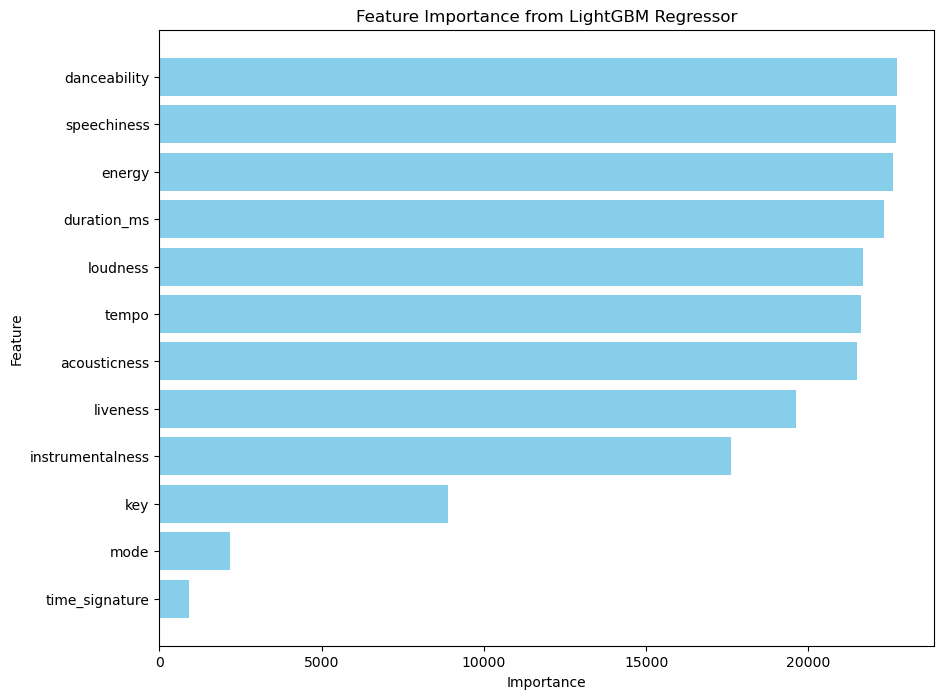

In [93]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error



# Finding the importance of the features
feature_importances = lgb_reg.feature_importances_

# Creating a DataFrame for easier representation
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sorting the DataFrame based on importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Printing the feature importances
print("Feature Importances:")
print(features_df)

# Creating the barplot
plt.figure(figsize=(10, 8))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from LightGBM Regressor')
plt.gca().invert_yaxis()  # Inverting the order to show the most important feature first
plt.show()


#

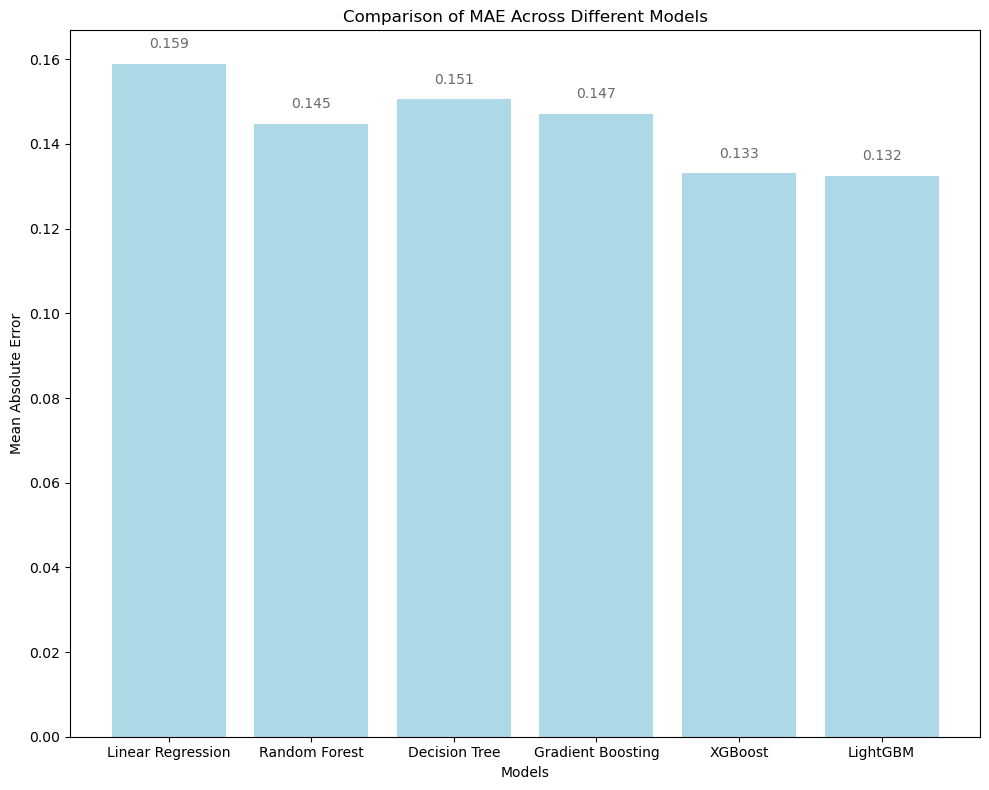

In [94]:
import matplotlib.pyplot as plt

# Υποθέτοντας ότι έχετε ήδη υπολογίσει τα mae_values για τα υπόλοιπα μοντέλα
mae_values = [mae_lin_reg, mae_rf, mae_dt, mae_gb, mae_xgb, mae_lgb]
model_names = ['Linear Regression', 'Random Forest', 'Decision Tree', 'Gradient Boosting', 'XGBoost', 'LightGBM']

# Δημιουργία του barplot
plt.figure(figsize=(10, 8))  
plt.bar(model_names, mae_values, color='lightblue')

plt.title('Comparison of MAE Across Different Models')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Models')

# Προσθήκη τιμών πάνω από τις μπάρες
for i, (name, value) in enumerate(zip(model_names, mae_values)):
    plt.text(i, value + 0.003, f'{value:.3f}', ha='center', va='bottom', color='dimgrey')

plt.tight_layout() 
plt.show()


he models compared include Linear Regression, Random Forest, Decision Tree, Gradient Boosting, XGBoost, and LightGBM.

From left to right, the height of each bar represents the MAE value for the corresponding model. Lower values of MAE indicate better predictive accuracy, as MAE measures the average magnitude of the errors in a set of predictions, without considering their direction.

The Linear Regression model has the highest MAE, suggesting that it may be the least accurate among the models for this particular dataset. The LightGBM model has the lowest MAE, indicating it has the best predictive accuracy and may be the most suitable model for this dataset based on this metric.

The chart provides a clear visual comparison, allowing us to quickly assess which models perform better in terms of prediction error. However, it's worth noting that while MAE is a useful metric for comparison, model selection should also consider other factors such as the complexity of the model, the interpretability, and how well it generalizes to new, unseen data.

#

## <font color="blue"> Dissecting Spotify Valence Holdout Dataset </font>


In [45]:
import pandas as pd
import os

file_name = 'spotify_ids_holdout.txt'
relative_path = os.path.join(os.getcwd(), file_name)

# Reading the dataset into a DataFrame
df = pd.read_csv(relative_path, header=None)  

# Display the first few rows to ensure it's loaded correctly
print(df.head())



                        0
0  7x9aauaA9cu6tyfpHnqDLo
1  56y1jOTK0XSvJzVv9vHQBK
2  3rUGC1vUpkDG9CZFHMur1t
3  01qFKNWq73UfEslI0GvumE
4  2YSzYUF3jWqb9YP9VXmpjE


### the code that exists inside the zip named spotify test dataset :

This Python code executes a series of steps to read a list of Spotify track IDs from a text file, retrieve audio features for each of these track IDs using the Spotify Web API through the Spotipy library, and finally, save this data to a CSV file.

Reading Spotify IDs: Initially, the code reads Spotify track IDs from a text file (spotify_ids_holdout.txt), which is located in the current working directory. Each line of the file contains a unique track ID.

Initializing Spotipy: Next, it uses Spotify client credentials (client ID and client secret) to initialize a Spotipy object, which will be used to make requests to the Spotify Web API.

Retrieving Audio Features: Using the Spotipy object, the script calls Spotify's audio_features API for each track ID, in batches of 100 at a time, to avoid rate limiting. Each response contains multiple features of the song, such as danceability, energy, and many more.

Creating DataFrame: All retrieved audio features are stored in a Pandas DataFrame, which provides a convenient data structure for storing and managing the data.

Saving Data to CSV: The final DataFrame with audio features is saved to a CSV file (spotify_audio_features_holdout.csv), allowing easy access and analysis of the data later.

Printing Samples: Finally, it prints the first samples from the DataFrame to confirm that the data has been loaded and formatted correctly.

This process provides an efficient method for retrieving and storing valuable information from the Spotify API, enabling further analysis and processing of the songs' audio features.

In [64]:
file_name = 'spotify_audio_features_holdout.csv'
file_path = os.path.join(os.getcwd(), file_name)

features_df = pd.read_csv(file_path)

print(features_df.head())

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.802   0.832   11    -4.107     1       0.0434        0.3110   
1         0.864   0.556    2    -7.683     0       0.1940        0.2550   
2         0.750   0.733    6    -3.180     0       0.0319        0.2560   
3         0.853   0.824    1    -3.287     1       0.1030        0.0322   
4         0.663   0.670    8    -8.399     1       0.2710        0.0464   

   instrumentalness  liveness  valence    tempo            type  \
0          0.000000    0.0815    0.890  124.997  audio_features   
1          0.000004    0.1120    0.726   99.974  audio_features   
2          0.000000    0.1140    0.844  111.018  audio_features   
3          0.000000    0.0859    0.888  108.044  audio_features   
4          0.000089    0.2050    0.138  136.952  audio_features   

                       id                                   uri  \
0  7x9aauaA9cu6tyfpHnqDLo  spotify:track:7x9aauaA9cu6tyfpHnqDLo   
1  56y1jOTK0

In [65]:
# Select specified columns
columns_to_select = [
    'danceability', 'energy', 'key', 'loudness', 'mode',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'duration_ms', 'time_signature'
]

In [66]:
# Creating a new DataFrame with the selected columns
dataset_for_test= features_df[columns_to_select]

In [67]:
dataset_for_test.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.802,0.832,11,-4.107,1,0.0434,0.3110,0.000000,0.0815,0.890,124.997,185427,4
1,0.864,0.556,2,-7.683,0,0.1940,0.2550,0.000004,0.1120,0.726,99.974,230480,4
2,0.750,0.733,6,-3.180,0,0.0319,0.2560,0.000000,0.1140,0.844,111.018,131872,1
3,0.853,0.824,1,-3.287,1,0.1030,0.0322,0.000000,0.0859,0.888,108.044,201812,4
4,0.663,0.670,8,-8.399,1,0.2710,0.0464,0.000089,0.2050,0.138,136.952,260111,4


In [68]:
Χ_songs_test = dataset_for_test.drop('valence', axis=1)
y_valence_test =dataset_for_test['valence']

In [96]:
y_pred_lin_reg_2 = lin_reg.predict(Χ_songs_test)   # Prediction on the test set
mae_lin_reg_2 = mean_absolute_error(y_valence_test, y_pred_lin_reg_2)  #  Calculating the MAE
print(f"MAE (Linear Regression): {mae_lin_reg_2}")

# Decision Tree
y_pred_dt_2 = best_model.predict(Χ_songs_test)  
mae_dt_2 = mean_absolute_error(y_valence_test, y_pred_dt_2)
print(f"MAE (Decision Tree): {mae_dt_2}")

# Random Forest Regressor
y_pred_rf_2 = rf_reg.predict(Χ_songs_test)
mae_rf_2 = mean_absolute_error(y_valence_test, y_pred_rf_2)
print(f"MAE (Random Forest): {mae_rf_2}")

# Gradient Boosting Regressor
y_pred_gb_2 = gb_reg.predict(Χ_songs_test)
mae_gb_2 = mean_absolute_error(y_valence_test, y_pred_gb_2)
print(f"MAE (Gradient Boosting): {mae_gb_2}")

# XGBoost Regressor
y_pred_xgb_2 = best_model2.predict(Χ_songs_test)
mae_xgb_2 = mean_absolute_error(y_valence_test, y_pred_xgb_2)
print(f"MAE (XGBoost): {mae_xgb_2}")

# LightGBM Regressor
y_pred_lgb_2 = lgb_reg.predict(Χ_songs_test)
mae_lgb_2 = mean_absolute_error(y_valence_test, y_pred_lgb_2)
print(f"MAE (LightGBM): {mae_lgb_2}")



MAE (Linear Regression): 0.16594003925355963
MAE (Decision Tree): 0.16436836771425944
MAE (Random Forest): 0.16116950437015606
MAE (Gradient Boosting): 0.15985933953828474
MAE (XGBoost): 0.14844978975700582
MAE (LightGBM): 0.14348351609090332


  - LightGBM: This model has the lowest MAE of approximately 0.143, indicating the best performance among the listed models. LightGBM is a gradient boosting framework that uses tree-based learning algorithms and is designed for distributed and efficient training.
  
   - XGBoost: This optimized gradient boosting model has a significantly better MAE of approximately 0.148. It's a strong model for many tabular datasets and is known for its performance and speed.

  
 - Linear Regression: This model has an MAE of approximately 0.166. As a basic predictive modeling technique, it's often used as a benchmark. The result indicates that, on average, the model's predictions are about 0.166 units away from the actual values.

 - Decision Tree: The MAE improves slightly to about 0.164. Decision Trees often have better performance than linear models because they can capture nonlinear relationships.

 - Random Forest: This ensemble model, which combines multiple decision trees, further reduces the MAE to approximately 0.161. The improvement suggests that the ensemble approach is better at capturing the complexity of the data than a single decision tree.

 - Gradient Boosting: Another ensemble technique that builds trees sequentially, each one correcting the errors of the previous, shows an MAE of about 0.160. This indicates a small but noticeable improvement over the Random Forest.


In summary, the boosting models (XGBoost and LightGBM) have outperformed the other models, indicating their superior ability to model the underlying patterns in the dataset. The ensemble methods (Random Forest, Gradient Boosting) generally performed better than the single Decision Tree and Linear Regression, which is consistent with expectations due to their ability to reduce variance and/or bias. LightGBM stands out as the best-performing model in this comparison, suggesting it may be the most suitable model for this particular prediction task.